# Talep Tahmin Modeli
Bu yazımda, Python ile Makine Öğrenimi tekniğini kullanarak uçtan uca bir talep tahmin modeli gerçekleştireceğim.

## 1 - Verisetini İnceleyelim
- Elimizde 10 farklı mağaza ve 50 farklı ürün çeşidine ait 5 yıllık satış verilerini içeren bir retail veri seti var.
- Amacımız store-item kırılımında 3 aylık ürün satışlarını tahmin edebilmek.

In [1]:
# import libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

# close warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [2]:
# read dataset, combining train and test dataset
train = pd.read_csv(r"C:/Users/HAZAL/OneDrive/Masaüstü/Projeler/product_demand_forecasting_model/train.csv", parse_dates=['date'])
test = pd.read_csv(r"C:/Users/HAZAL/OneDrive/Masaüstü/Projeler/product_demand_forecasting_model/test.csv", parse_dates=['date'])
sample_sub = pd.read_csv(r"C:/Users/HAZAL/OneDrive/Masaüstü/Projeler/product_demand_forecasting_model/sample_submission.csv")

data = pd.concat([train, test], sort=False)

In [3]:
# first look at the dataset
data.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


#### Değişkenler

- date — Satış verilerinin tarihi
- store — Mağaza ID
- item — Ürün ID
- sales — Belirli bir tarihte belirli bir mağazada satılan ürün sayısı

→ id değişkeninde NaN değerlerin olması train veri setinde değişkenin bulunmamasından dolayıdır.

## 2 - Keşifçi Veri Analizi(EDA)
Veri setindeki minimum ve maximum tarihi gözlemleyecek olursak, buradan da elimizdeki veri setinin toplamda 5 yıllık bir datayı içerdiğini doğrulayabiliriz.

In [4]:
data['date'].min(), data['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

#### Train verisetini inceleme
- Toplamda 913000 gözleme sahip
- date, store, item, sales olmak üzere toplamda 4 adet değişkene sahip
- Hiç NA değer yok

In [5]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
train.shape

(913000, 4)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


#### Test verisetini inceleme
- Toplamda 45000 gözleme sahip
- id, date, store, item olmak üzere toplamda 4 adet değişkene sahip
- Hiç NA değer yok

In [8]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [9]:
test.shape

(45000, 4)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


#### Sample Submission Veriseti
-  Toplamda 45000 gözleme sahip
- id ve sales olmak üzere toplamda 2 adet değişkene sahip
- Hiç NA değer yok

In [11]:
sample_sub.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [12]:
sample_sub.shape

(45000, 2)

In [13]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


### Verisetinde Eksik Değer Kontrolü

In [14]:
data.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

id değişkeninde 913000 adet eksik değer var. Bunun sebebi train veri setinde id bulunmamasıdır. Aynı şekilde sales değişkenindeki 45000 adet gözlemin eksikliği de, test veri setinde sales değişkeninin bulunmamasından kaynaklanıyor.

Başlarken train ve test veri setlerini birleştirdiğimiz için böyle bir durumla karşılaştık. Dolayısıyla şuanda veri setinde herhangi bir eksiklik ya da aykırılık söz konusu değildir.

### Verisetinde Aykırı Değer Olup Olmaması Kontrolü

In [15]:
from scipy import stats

def find_outliers_zscore(data, threshold=3, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    
    # Exclude specified columns from z-score calculation
    data_for_zscore = data.drop(exclude_cols, axis=1) if exclude_cols else data
    
    z_scores = stats.zscore(data_for_zscore)
    
    # Check for outliers excluding specified columns
    return (np.abs(z_scores) > threshold).any(axis=1)

# Exclude 'date' column from z-score calculation
are_outliers = find_outliers_zscore(data, exclude_cols=['date'])
print("Aykırı Değer Var mı:", are_outliers)


Aykırı Değer Var mı: 0        False
1        False
2        False
3        False
4        False
         ...  
44995    False
44996    False
44997    False
44998    False
44999    False
Length: 958000, dtype: bool


##### Satış dağılımı 

In [16]:
data["sales"].describe().T

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

##### Mağaza sayısı

In [17]:
data["store"].nunique()

10

##### İtem sayısı

In [18]:
data["item"].nunique()

50

##### Her store'da eşit sayıda unique item olup olmama kontrolü

In [19]:
data.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

Mağazalardaki eşsiz ürün sayıları

##### Store-item kırılımında satışların betimsel istatistikleri

In [20]:
data.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

Her store'da toplam ürün satış sayıları farklılık gösteriyor.

## 3 - Değişken Mühendisliği(Future Engineering)

Geçmişe ilişkin level, trend, mevsimsellik ve model bilgilerini üreteceğimiz değişkenlerle yeni modele yansıtmamız gerekiyor

##### Yeni değişkenler üretmeden önceki değişken sayımız

In [21]:
data.shape

(958000, 5)

Mevcut gözlem sayısı

##### Date Features(Tarih değişkenleri)

In [22]:
def create_date_features(data):
    data["month"] = data.date.dt.month
    data["day_of_month"] = data.date.dt.day
    data["day_of_year"] = data.date.dt.dayofyear
    data["week_of_year"] = data.date.dt.weekofyear
    data["day_of_week"] = data.date.dt.dayofweek + 1 # Pazartesi günü 0 kabul edildiği için +1 eklemesi yapıldı
    data["year"] = data.date.dt.year
    data["is_wknd"] = data.date.dt.weekday // 4 # Verisetindeki ilk gün 1 ile başlar yani Salı günüdür. 
    # Bundan yararlanarak alışverişlerin sıklıkla gerçekleştiği haftasonu günlerini yakalamak için 4' bölümünden kalan sorgusunu gerçekleştirdik. 
    # Sonuç olarak Cuma, Cumartesi ve Pazar günleri 1 olarak dönerken diğer günler 0 Oldu.
    data["is_month_start"] = data.date.dt.is_month_start.astype(int) # Ayın başlangıç bilgisini verir.
    data["is_month_end"] = data.date.dt.is_month_end.astype(int) # Ay sonu bilgisini verir.
    return data

In [23]:
data = create_date_features(data)

In [24]:
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0


0. indexe bakarsak, veri seti 2013–01–01 tarihi ile başlıyor. Bu tarih yeni oluşturduğumuz yılın ilk günü, ilk haftası ve ilk ayı değişkenlerinde 1 değerini alırken, haftanın day_of_week değişkeninde 2 değerine sahip. Yani bu da Salı gününü ifade ediyor.

##### Aylara göre ürün satışlarının istatistikleri

In [25]:
data.groupby(["store", "item", "month"]).agg({"sales": ["count", "sum", "mean", "median", "std"]})

sales                                      
                 count      sum       mean median        std
store item month                                            
1     1    1       155   2125.0  13.709677   13.0   4.397413
           2       141   2063.0  14.631206   14.0   4.668146
           3       155   2728.0  17.600000   17.0   4.545013
           4       150   3118.0  20.786667   20.0   4.894301
           5       155   3448.0  22.245161   22.0   6.564705
...                ...      ...        ...    ...        ...
10    50   8       155  13108.0  84.567742   85.0  15.676527
           9       150  11831.0  78.873333   79.0  15.207423
           10      155  11322.0  73.045161   72.0  14.209171
           11      150  11549.0  76.993333   77.0  16.253651
           12      155   8724.0  56.283871   56.0  11.782529

[6000 rows x 5 columns]

#### Random Noise(Rastgele Gürültü)

Zaman serisi ve makine öğrenimi modellerinde overfitting(aşırı öğrenme) kavramının önüne geçmek için, verisetindeki değişkenler üzerinden yeni değişkenler türetirken, var olan değişkenlerin özelliklerine random noise(rastgele gürültü) eklenir.

In [26]:
def random_noise(data):
    return np.random.normal(scale=1.6, size=(len(data),))

Random noise fonksiyonu

In [27]:
np.random.normal(scale=1.6, size=(len(data),))

array([ 1.99973808, -0.66465058,  2.16802402, ..., -0.48609372,
       -1.61219941,  0.33154488])

Pattern'i bozmak adına veriye rastgele değerler(gürültü) eklendi.

#### Lag/Shifted Features(Geçmiş Verilere İlişkin Değerler)

Öncelikle elimizdeki verileri daha düzenli bir formata getirelim.

In [28]:
data.sort_values(by=["store", "item", "date"], axis=0, inplace=True)

In [29]:
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0


Elimizdeki sales verisi ile bir önceki sales verisini aynı satıra getirip karşılaştırma yapmaya çalışalım.

In [30]:
pd.DataFrame({"sales": data["sales"].values[0:10],
    
               "lag1": data["sales"].shift(1).values[0:10],
               "lag2": data["sales"].shift(2).values[0:10],
               "lag3": data["sales"].shift(3).values[0:10],
               "lag4": data["sales"].shift(4).values[0:10]
             })

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


sales kolonunda dataframedeki orjinal sales değerlerimiz bulunuyor.

lag1, lag2, lag3 ve lag4 ile ifade edilen değerler ise gecikmeleri yani bir önceki değerleri bulunduruyor.

2.indekstteki 14 değerini incelediğimizde; sol tarafta 14'ten önce 11 ve 13 değerleri bulunuyor. Bu nedenle sağ tarafta lag1=11, lag2=13, 13'ten önce başka geçmiş değer bulunmadığı için lag3 ve lag4 NaN olarak ifade edilmektedir.

Diğer indeksleri de bu şekilde inceleyebiliriz.

Bunu yapmamızın temel amacı zaman serisindeki modellerin (örneğin SES modeli) kendinden bir önceki değerden daha çok etkileniyor olmasıdır.

In [31]:
def lag_features(data, lags):
    data = data.copy()
    for lag in lags:
        data["sales_lag_" + str(lag)] = data.groupby(["store","item"])["sales"].transform(
            lambda x: x.shift(lag)) + random_noise(data)
    return data

Lag/shifted işleminin fonksiyonlaştırılması

In [32]:
data = lag_features(data, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

Hesaplamada kullanılacak periyotların belirlenmesi

##### Neden bu değerleri seçtik?
Bizden 3 aylık bir tahmin yapmamız isteniyor. Bu nedenle periyotları belirlerken 3 aylık tahminle başlayıp, 1 haftalık süreyi üzerine ekleyerek devam ettik.

Verisetinin son haline bakalım.

In [33]:
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Rolling Mean Features(Hareketli Ortalama Değişkenleri)

In [34]:
pd.DataFrame({"sales": data["sales"].values[0:10],
         "roll2": data["sales"].rolling(window=2).mean().values[0:10],
         "roll3": data["sales"].rolling(window=3).mean().values[0:10],
         "roll5": data["sales"].rolling(window=5).mean().values[0:10]
        })

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


Hareketli ortalama rolling fonksiyonu ile hesaplanır. Yukarıdaki kod parçasında ifade edilen window ise, hareketli ortalamada kendinden önce kaç gecikme(lag) dikkate alınacağımızı göstermektedir.

2.indekse bakacak olursak sales değeri 14 olan değerden önce 13 ve 11 olan yalnızca 2 adet sales değeri bulunuyor.

Kendisi de dahil olmak üzere roll2(window=2) hareketli ortalamasını hesaplayacak olursak:
roll2 = (sales+lag1)/2
roll2 = (14+11)/2
roll2 = 12.5

Kendisi de dahil olmak üzere roll3(window=3) hareketli ortalamasını hesaplayacak olursak:
roll3 = (sales+lag1+lag2+lag3)/3
roll3 = (14+11+10)/3
roll3 = 12.6

Bu hesaplamayı yaparken gözlem değerinin kendi değerini de hesaba kattık. Ama biz geçmiş değerlere ilişkin trende ulaşmaya çalışıyoruz. Bunun için de mevcut değerden bağımsız yeni bir feature türetmeye çalışmalıyız ki ancak o zaman geçmişteki trendi ifade edebilelim.

##### Bunu nasıl yapabiliriz?
Sales değerinin kendisini çıkarmak için hareketli ortalama hesabını yapmadan önce 1 adım shift/lag(gecikme) yaparsak sorun çözülecektir.

In [35]:
pd.DataFrame({"sales": data["sales"].values[0:10],
         "roll2": data["sales"].shift(1).rolling(window=2).mean().values[0:10],
         "roll3": data["sales"].shift(1).rolling(window=3).mean().values[0:10],
         "roll5": data["sales"].shift(1).rolling(window=5).mean().values[0:10]
        })

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


Shift işlemi uygulanmış rolling mean hesabı

In [36]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(["store","item"])["sales"]. \
                                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [37]:
data = roll_mean_features(data, [365, 546])

Yukarıdaki işlemin fonksiyonlaştırılmış hali

In [38]:
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En sondaki yeni oluşturduğumuz 2 değişkene odaklandığımızda ilk 5 indeksteki değerlerin hepsinin NaN olduğunnu görüyoruz.

##### Bunun sebebi nedir?
date değişkeninde göreceğimiz üzere bu çıktı verisetinin 2013 yılının ilk ayına ait verileri içermektedir. Train veriseti ise 2017 tarihi ile sonlanmaktadır. Bizim tahmin etmek istediğimiz değerler zaten 2018'in ilk 3 ayına ait olacak. 

SES modelinden de hatırlayacağımız üzere tahmin edeceğimiz bu değerler yakın geçmişten daha fazla etkileneceğinden, 2017'nin son aylarına ait hareketli ortalama değişkenleri NaN olmayacaktır.

In [39]:
data.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,2,2018,0,0,0,43.487819,53.007730,68.209280,69.071764,68.991945,79.064768,78.571431,59.317564,94.015369,74.329653,88.764920,87.400616
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,3,2018,0,0,0,63.249332,50.795966,66.185456,58.726715,75.823511,83.039556,79.752710,74.842145,81.406677,69.324891,87.141885,85.937874
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,4,2018,0,0,0,59.315660,63.690430,72.886731,62.514990,73.450259,89.009806,80.582174,67.819418,101.496073,74.528135,86.150525,85.428641
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,5,2018,1,0,0,73.856676,74.772126,69.320515,69.050467,65.504933,79.842241,89.441813,68.108518,78.850676,80.987186,87.251635,87.048450
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,6,2018,1,0,1,60.928264,70.370721,50.239654,68.637181,50.357287,76.236738,102.788411,100.396574,99.668926,78.082360,89.036816,85.240851


#### Exponentially Weighted Mean Features(Üssel Ağırlıklı Ortalama Değişkenleri)

In [40]:
pd.DataFrame({"sales": data["sales"].values[0:10],
              "roll2": data["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": data["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": data["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": data["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": data["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]
        })

,sales,roll2,ewm099,ewm095,ewm07,ewm01
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


Üssel ağırlıklı ortalama hesabı

Üssel ağırlıklı ortalama ewm fonksiyonu ile hesaplanır. shift(1) yani "1 adım kaydır" ifadesini bir önceki örnekte de hesaplama yaparken, değişkenin kendi değerinin alınmaması için kullanmıştık. Farklı olarka burada alpha değeri eklenmiş oldu.

Alpha geçmiş değerlere ne kadar önem vereceğimizi belirttiğimiz bir parametredir. Yakın geçmişe ağırlık vermek istersek alpha değerini 1'e yakın seçeriz, uzak değerlere önem vermek istiyorsak da 0'a yakın bir değer belirleyebiliriz.

Çıktıyı yorumlayalım:

2.indekse baktığımızda sales değeri 14, roll2 değeri 12, ewm099 değişken hesabına ait alpha değeri ise 0.99 olarak alınmış. Yakın geçmişe daha fazla ağırlık verilmesini istediğimiz için alpha değeri 1'e yakın. Bu nedenle üssel ağırlıklı ortalama sonucumuz en yakın geçmiş olan 11 değerine daha yakın olarak 11.09 çıktı.

ewm01 değişken hesabına ait i alpha değeri ise 0.1 olarak alındı. Bir önceki durumun tam tersi olarak bu sefer 11 değerine daha uzak olmasını bekleriz. Nitekim sonucumuz 11.94 olarak elde edlmiştir. Aynı şekilde diğer gözlemleri de  yorumlayabiliriz.

In [41]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha_" + str(alpha).replace(".","") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])["sales"]. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

ewm işleminin fonksiyonlaştırılmış hali

In [42]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [43]:
data = ewm_features(data, alphas, lags)

alpha ve lags değerleri

En başta 4 değişkenle yola çıkmıştık. Şuanda elimizde 71 adet yeni değişkenimiz var.

In [44]:
data.shape

(958000, 71)

In [45]:
data.columns

Index(['date', 'store', 'item', 'sales', 'id', 'month', 'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week', 'year', 'is_wknd', 'is_month_start', 'is_month_end', 'sales_lag_91', 'sales_lag_98', 'sales_lag_105', 'sales_lag_112', 'sales_lag_119', 'sales_lag_126', 'sales_lag_182', 'sales_lag_364', 'sales_lag_546', 'sales_lag_728', 'sales_roll_mean_365', 'sales_roll_mean_546', 'sales_ewm_alpha_095_lag_91', 'sales_ewm_alpha_095_lag_98', 'sales_ewm_alpha_095_lag_105',
       'sales_ewm_alpha_095_lag_112', 'sales_ewm_alpha_095_lag_180', 'sales_ewm_alpha_095_lag_270', 'sales_ewm_alpha_095_lag_365', 'sales_ewm_alpha_095_lag_546', 'sales_ewm_alpha_095_lag_728', 'sales_ewm_alpha_09_lag_91', 'sales_ewm_alpha_09_lag_98', 'sales_ewm_alpha_09_lag_105', 'sales_ewm_alpha_09_lag_112', 'sales_ewm_alpha_09_lag_180', 'sales_ewm_alpha_09_lag_270', 'sales_ewm_alpha_09_lag_365', 'sales_ewm_alpha_09_lag_546', 'sales_ewm_alpha_09_lag_728', 'sales_ewm_alpha_08_lag_91',
       'sales_ewm_alpha_08_lag_98'

#### One Hot Encoding Yöntemi

In [46]:
data = pd.get_dummies(data, columns=["store","item","day_of_week","month"])

store, item, day_of_week ve month değişkenleri veri setinden çıkarıldı

One-Hot Encoding işleminden sonra 146 adet yeni değişkenimiz oldu.

In [47]:
data.shape

(958000, 146)

In [48]:
data.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

#### Logaritmik Dönüşüm

Gradient Descent kullandığımız yöntemlerde değişkenin orjinal halinde kalması iterasyon sayısını artırabilir. Bunun önüne geçmek için bağımlı değişken(sales) üzerinde logaritmik dönüşüm uygulayacağız.

In [49]:
data["sales"] = np.log1p(data["sales"].values)

Tekrar kullancak olduğumuz zaman geri dönüştürmeyi unutmayalım!!!

### 4 - Custom Cost Function

Cost Function'ların Custom olması ne anlama gelir?

Bir iterasyonda train hatasıyla validasyon hatasının birbirinden çok farklılaştığı noktadaki durumu overfitting olarak değerlendiririz. Hata metriğine göre gözlem yaparak(manuel) karar veririz.
Dolayısıyla bu hatayı ilgili problem için ölçecek olan fonsiyon öyle bir fonksiyon olmalı ki, bana nerede duracağımı farklı alternatiflerle göstermeli.

Regresyon problemleri için genel olarak en sık kullandığımız cost functionlar: MSE, RMSE, MAE

Bu problem için aslında MAE fonksiyonu kullanılabilir. Ama biz burada farklı olarak MAPE ve SMAPE fonksiyonlarını ele alacağız.

##### MAPE - Ortalama Mutlak Yüzde Hata (Mean Absolute Percentage Error)
Regresyon ve zaman serileri modellerinde tahminlerin doğruluğunu ölçmek için ortalama mutlak yüzde hata sıkça kullanılmaktadır. Gerçek değerler arasında sıfır içerenler varsa, sıfır ile bölünme olacağından MAPE hesaplanamaz. Çok düşük tahmin değerleri için yüzde hatası %100'ü geçemez, ancak çok yüksek tahmin değerleri olduğunda yüzde hatasının üst sınırı yoktur.

##### SMAPE - Simetrik Ortalama Mutlak Yüzde Hata (Symmetric Mean Absolute Percentage Error

"Adjusted MAPE"

Öğeler için sıfır veya sıfıra yakın talep olduğunda Ortalama Mutlak Yüzde Hata (MAPE) alternatifidir. SMAPE, bu düşük hacimli öğelerin etkisini azaltarak,% 200’lük bir hata oranına kendini sınırlar. Düşük hacimli öğeler sorunludur, aksi halde genel hata oranını çarpıtan sonsuz yüksek hata oranlarına sahip olabilirler.

SMAPE, tahmini eksi gerçek değerleri, bu formülde ifade edilen tahminlere ve fiili toplamlara bölünür. 

In [50]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

SMAPE formülünün fonksiyonlaştırılması

### 5 - Model Validation
Validasyon setini nasıl belirleyeceğiz?

Klasik olarak train ve ve test setini split edip modele sokabiliriz. Fakat sonuçlar yanıltıcı olacaktır. Bu nedenle validasyonu zaman ayarlı yapamamız gerekiyor.

##### Time-Based Validation Sets
Bizden 2018 yılının ilk 3 ayına ait tahminler bekleniyordu.

In [51]:
# test seti min-max date
test["date"].min(), test["date"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [52]:
# train seti min-max date
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

##### Train ve validasyon setini neye göre seçeceğiz?
2017'nin başına kadar(2016'nın sonuna kadar) olan verileri train seti olarak belirleyelim.

In [53]:
train  = data.loc[(data["date"] < "2017-01-01"), :]

In [54]:
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

Train setinin belirlenmesi

#### 2017'nin ilk 3 ayına ait verileri de validasyon seti olarak belirleyelim.

In [55]:
# Validasyon setinin belirlenmesi
val = data.loc[(data["date"] >= "2017-01-01") & (data["date"] < "2017-04-01"), :]

In [56]:
val["date"].min(), val["date"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-03-31 00:00:00'))

Train ve validasyon setlerimiz hazır. Şimdi bağımlı ve bağımsız değişkenleri tespit etmemiz gerekiyor.

In [57]:
# Bağımsız değişkenlerin seçilmesi
cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

In [58]:
# Train seti bağımlı ve bağımsız değişkenlerin belirlenmesi
Y_train = train["sales"]
X_train = train[cols]

In [59]:
# Validasyon seti bağımlı ve bağımsız değişkenlerin belirlenmesi
Y_val = val["sales"]
X_val = val[cols]

### LightGBM Model

In [60]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'early_stopping_rounds':200,
              'num_boost_round': 1000,
              'nthread': -1}

metric : {mae} ➡ Düzenlileştirme terimidir. Mutlak normu ifade eder.

num_leaves ➡ Max yaprak sayısı.

learning_rate ➡ Modelin öğrenirken atacağı adımı sembolize eder.

feature_fraction ➡ Her iterasyonda LightGBM için göz önünde bulundurulacak değişken sayısını ifade eder.

max_depth ➡ Ağacın max derinliği.

verbose ➡ Ekrana verilecek bilgiyi ifade eder.

num_boost_round ➡ İterasyon sayısı.

early_stopping_rounds ➡ Burada belirlediğimiz parametreye kadar validasyon setinde artık hata değeri düşmüyorsa, modelin num_boost_round’da belirlediğimiz iterasyona kadar çalışmasına gerek kalmaz, durur. Overfitting’in önüne geçmek için önemli bir parametredir.

nthread : -1 ➡ Tüm işlemcilerin ful performans kullanılmasını sağlar. İşlemci sayısı yazılarak da kullanılabilir.

In [61]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [62]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds = lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263489 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.142298	training's SMAPE: 14.574	valid_1's l1: 0.145115	valid_1's SMAPE: 14.8867
[400]	training's l1: 0.134578	training's SMAPE: 13.8022	valid_1's l1: 0.138948	valid_1's SMAPE: 14.2684
[600]	training's l1: 0.132268	training's SMAPE: 13.5717	valid_1's l1: 0.136722	valid_1's SMAPE: 14.0447
[800]	training's l1: 0.130993	training's SMAPE: 13.4442	valid_1's l1: 0.13538	valid_1's SMAPE: 13.9097
[1000]	training's l1: 0.130099	training's SMAPE: 13.3545	valid_1's l1: 0.134575	valid_1's SMAPE: 13.8286
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.130099	training's SMAPE: 13.3545	valid_1's l1: 0.134575	valid_1's SMAPE: 13.8286


In [63]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.828623138246815

                         feature  split       gain
17           sales_roll_mean_546    916  54.387156
13                 sales_lag_364   1232  13.024912
16           sales_roll_mean_365    636   9.877789
60    sales_ewm_alpha_05_lag_365    361   5.018352
18    sales_ewm_alpha_095_lag_91     82   2.685175
1                    day_of_year    755   2.070213
54     sales_ewm_alpha_05_lag_91     85   1.870062
3                        is_wknd    232   1.218584
123                day_of_week_1    233   1.192260
141                     month_12    324   1.166695
36     sales_ewm_alpha_08_lag_91     24   0.943036
6                   sales_lag_91     78   0.912785
2                   week_of_year    285   0.910944
27     sales_ewm_alpha_09_lag_91     30   0.479395
7                   sales_lag_98     19   0.466475
62    sales_ewm_alpha_05_lag_728    402   0.397857
44    sales_ewm_alpha_08_lag_728     27   0.357335
51    sales_ewm_alpha_07_lag_365     58   0.349908
59    sales_ewm_alpha_05_lag_27

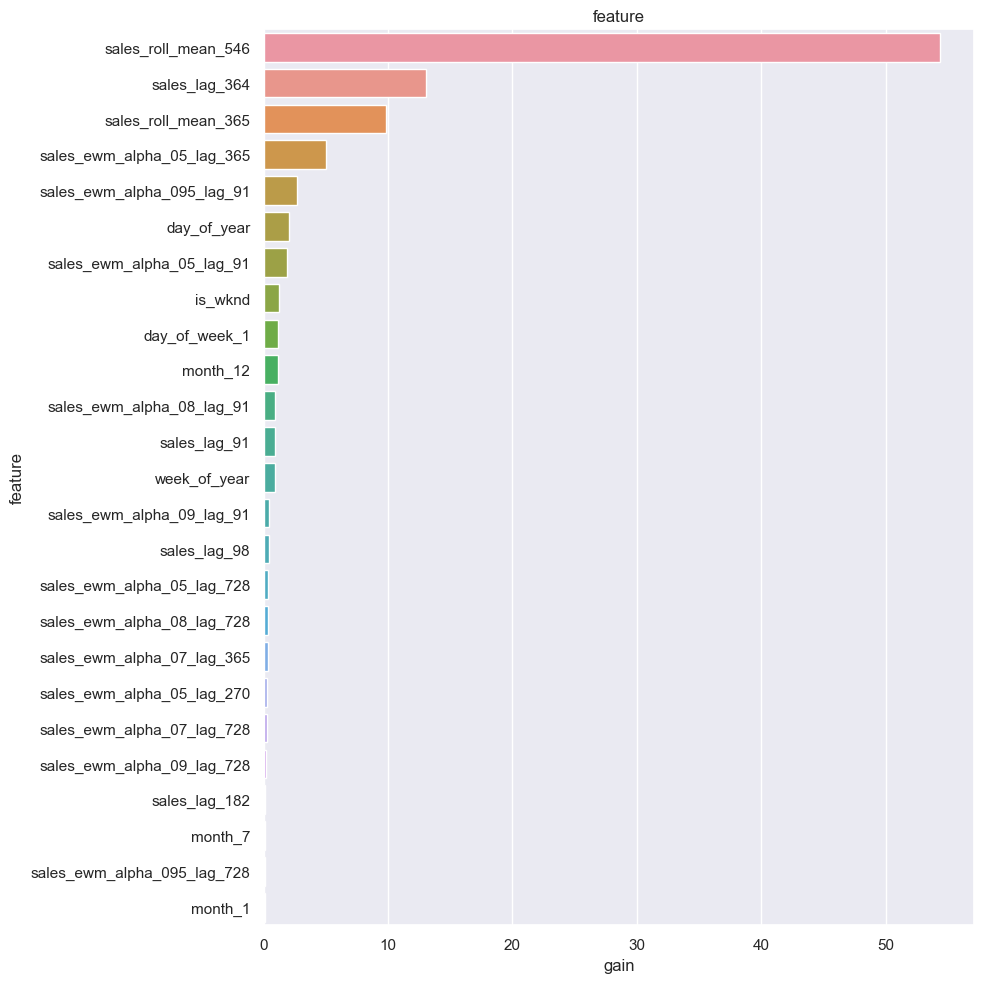

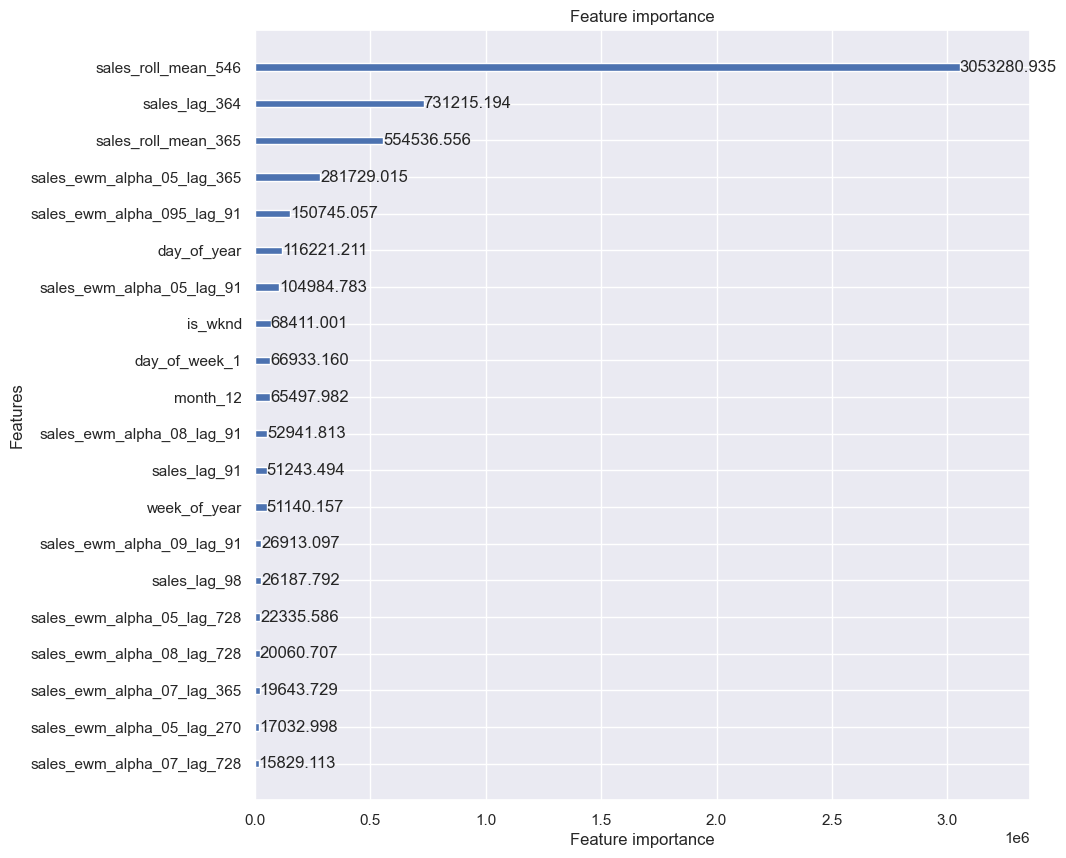

In [64]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)

plot_lgb_importances(model, plot=True, num=30)



lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

#### Final Model

In [65]:
train = data.loc[~data.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = data.loc[data.sales.isna()]
X_test = test[cols]

In [66]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


In [67]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284832 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [68]:
test_preds

array([2.59133444, 2.68225477, 2.70681563, ..., 4.36280689, 4.41315101,
       4.47190458])

In [69]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df

,id,sales
0,0.0,NaN
1,1.0,NaN
2,2.0,NaN
3,3.0,NaN
4,4.0,NaN
...,...,...
44995,44995.0,NaN
44996,44996.0,NaN
44997,44997.0,NaN
44998,44998.0,NaN


In [70]:
submission_df['sales'] = np.expm1(test_preds)

In [71]:
submission_df['id'] = submission_df.id.astype(int)

In [72]:
submission_df.to_csv('kaggle_submission.csv', index=False)